In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
from torchvision.models import alexnet
model = alexnet(num_classes=10, pretrained=False).to(device)

/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server-96gb-ailab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/100] 	 Loss: 1.82670     Accuracy: 31.58% 	 Test Loss: 1.59940     Test Accuracy: 40.02%
Epoch [  2/100] 	 Loss: 1.44698     Accuracy: 47.62% 	 Test Loss: 1.29956     Test Accuracy: 53.34%
Epoch [  3/100] 	 Loss: 1.28386     Accuracy: 53.95% 	 Test Loss: 1.12293     Test Accuracy: 59.89%
Epoch [  4/100] 	 Loss: 1.19086     Accuracy: 57.55% 	 Test Loss: 1.14298     Test Accuracy: 59.48%
Epoch [  5/100] 	 Loss: 1.11598     Accuracy: 60.52% 	 Test Loss: 1.10586     Test Accuracy: 60.92%
Epoch [  6/100] 	 Loss: 1.05790     Accuracy: 62.41% 	 Test Loss: 1.01153     Test Accuracy: 64.28%
Epoch [  7/100] 	 Loss: 1.02135     Accuracy: 64.21% 	 Test Loss: 1.00720     Test Accuracy: 64.04%
Epoch [  8/100] 	 Loss: 0.97608     Accuracy: 65.55% 	 Test Loss: 0.98288     Test Accuracy: 65.40%
Epoch [  9/100] 	 Loss: 0.93956     Accuracy: 66.82% 	 Test Loss: 1.06659     Test Accuracy: 62.45%
Epoch [ 10/100] 	 Loss: 0.90936     Accuracy: 68.04% 	 Test Loss: 0.93557     Test Accuracy: 67.05%


In [9]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 92 with test accuracy: 71.99%


# Plot results

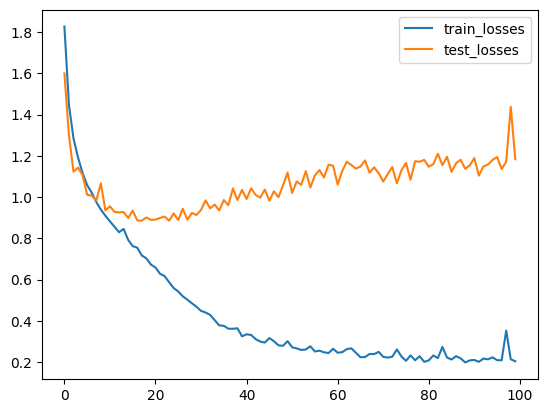

In [10]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

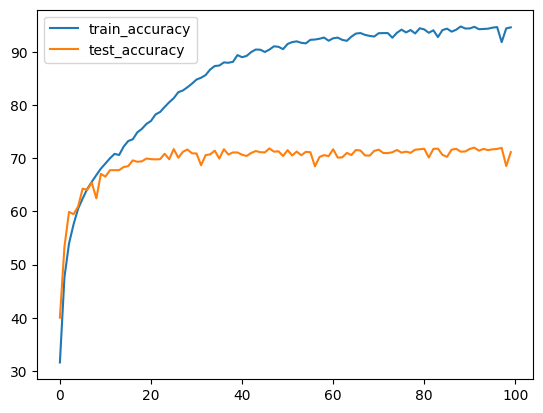

In [11]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()